# Importing libraries and defining functions

In [4]:
%pip install transformers
%pip install gensim
%pip install openai
%pip install rake-nltk
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                                              0.0/60.5 kB ? eta -:--:--
     ---------------------------------------- 60.5/60.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191687 sha256=55ce26008b5fec22f2ecc2db8047ba4e9455b61effb35a145929e1ea6892e3b2
  Stored in directory: c:\users\visha\appdata\local\pip\cache\wheels\2f\8a\0d\cc013998ab7499084d308981bf7850bdedeb27d75dd7ec501d
Successfully built pyrouge
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from textblob import TextBlob
from dateutil.relativedelta import relativedelta
import dateutil.parser
from datetime import datetime
import time
import re
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import TweetTokenizer
from gensim.models import Phrases
from gensim import corpora
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
import openai
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.probability import FreqDist
from transformers import pipeline
from rake_nltk import Rake
import gensim
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate import meteor_score as nltk_meteor_score

[nltk_data] Downloading package wordnet to C:\Users\visha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\visha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\visha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
# Setting OpenAI API key
openai.api_key = 'sk-UNqVv5RIZs2Mv58ABRfbT3BlbkFJgDzZO3nITCXSVuln1'

In [81]:
def clean_text(text):
    text = text.lower()                                                      # Convert text to lowercase
    text = re.sub(r'\[.*?\]', '', text)                                      # Remove text inside square brackets
    punctuation = string.punctuation.replace(':', '')                        # Create a new punctuation string without ':'
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)                # Remove punctuation marks using the new string
    text = re.sub(r'\w*\d\w*', '', text)                                     # Remove words containing numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)                        # Remove URLs
    text = re.sub(r'\W', ' ', text)                                          # Replace non-word characters with a space
    text = re.sub('[‘’“”…]', '', text)                                       # Remove special characters
    text = re.sub('\n', ' ', text)                                           # Replace newline characters with a space
    text = text.replace(':', ' ')                                            # Replace ':' with a space
    text = re.sub(r'[^\x00-\x7F]+', '', text)                                # Remove non-ASCII characters
    lemmatizer = WordNetLemmatizer()                                         # Create a WordNet lemmatizer object
    tokens = nltk.word_tokenize(text)                                        # Tokenize the text into individual words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]    # Lemmatize each token
    text = ' '.join(lemmatized_tokens)                                       # Join the lemmatized tokens back into a text
    
    return text


In [82]:
company = "Amazon" # We can change it to any ecommerce/retail industry company/business
company1 = "amazon"

## Articles

In [16]:
# Web scrapping of articles
base_url = 'https://www.retaildive.com'
topic_urls = [
    "https://www.retaildive.com/search/"
]

def get_article_links(topic_url, page_number):
    url = f'{topic_url}?page={page_number}&q={company}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_links = soup.select('.feed__title a')
    links = []
    for link in article_links:
        url = link['href'] if link['href'].startswith(base_url) else base_url + link['href']
        if url not in visited_urls:
            links.append(url)
            visited_urls.add(url)
    return links


pages_to_scrape = list(range(1, 10))

all_article_links = []
visited_urls = set()

for topic_url in topic_urls:
    for page_number in pages_to_scrape:
        article_links = get_article_links(topic_url, page_number)
        all_article_links.extend(article_links)

def parse_date(date_string):
    try:
        # Remove "Published " if it's present
        date_string = date_string.replace("Published ", "")
        
        # Try to parse the date string using dateutil
        return dateutil.parser.parse(date_string)
    except ValueError:
        # If the date string is in an unrecognized format, return None
        return None

one_year_ago = datetime.now() - relativedelta(years=1)

crisis_keywords = ["Product recall", "Bankruptcy", "Store closure", "Data breach", "Supply chain disruption", "Strike",
                   "Labor dispute", "Boycott", "Fraud", "Inventory problem", "Lawsuit", "Regulatory violation",
                   "Health and safety violation", "Economic downturn", "Consumer complaint", "Public relations disaster",
                   "Security breach", "Outage", "Shipping disruption", "Production halt", "Brand crisis", "Profit warning",
                   "Recall", "Cyberattack", "Inflation", "Competition", "Loss of key partner", "Scandal", "Insolvency",
                   "Strike action", "Pandemic", "Natural disaster", "Product contamination", "Retail crisis", "Retail downturn",
                   "Retail bankruptcy", "Store closures", "Retail layoffs", "Falling sales", "Decreasing profits", "Overstock",
                   "Supply chain issues", "High retail vacancy", "E-commerce competition", "Online shopping surge",
                   "Brick-and-mortar decline", "Retail restructuring", "Retail debt", "Consumer behavior changes",
                   "Decreased foot traffic", "Retail disruption", "Shift to digital", "Retail insolvency", "Retail liquidation",
                   "Retail job cuts", "Retail industry collapse", "Retail market contraction", "Retail pandemic impact",
                   "Changes in retail trends", "Retail innovation challenges", "Omni-channel retailing struggles",
                   "Rising retail rent", "E-retail growth", "Retail technology adaptation", "Inventory management issues",
                   "Retail real estate crisis", "High street crisis", "Retail apocalypse", "Decline of shopping malls",
                   "Retail margin squeeze", "Loss of consumer confidence", "E-commerce crisis", "Online sales decline",
                   "E-commerce bankruptcy", "E-commerce fraud", "Data breach", "Cybersecurity threats", "Delivery issues",
                   "Supply chain disruptions", "Inventory management problems", "Consumer trust issues", "Decreased online traffic",
                   "Online customer retention issues", "Digital customer service complaints", "Payment gateway issues",
                   "E-commerce platform downtime", "Privacy concerns", "Negative online reviews", "E-commerce legal issues",
                   "Regulatory challenges for e-commerce", "Technology adaptation failures", "E-commerce site usability issues",
                   "Mobile commerce problems", "Social commerce challenges", "E-commerce return policy abuse", "International shipping issues",
                   "E-commerce tax issues", "Cross-border e-commerce difficulties", "E-commerce SEO problems",
                   "Lack of personalization in e-commerce", "Abandoned shopping carts", "E-commerce conversion rate decline",
                   "E-commerce accessibility issues", "E-commerce localization challenges", "Sustainability concerns in e-commerce",
                   "Product quality complaints", "E-commerce vendor disputes", "E-commerce advertising backlash", "Dropshipping difficulties",
                   "E-commerce platform migration problems", "Downfall"]

articles = []

for url in all_article_links:

#    response = requests.get(url)
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'
    }
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.text, "html.parser")

    title_element = soup.find("h1", class_="display-heading-04")
    
    # If the title element is not found, skip the iteration
    if title_element is None or company not in title_element.get_text(strip=True):
        continue

    title = title_element.get_text(strip=True)

    published_date = soup.find("span", class_="published-info").get_text(strip=True)
    published_date_parsed = parse_date(published_date)
#    print(published_date_parsed)
    article_body = soup.find("div", class_=["add-drop-cap large medium article-body", "large medium article-body"])

    # If the date is None or more than one year old, skip this article
    if published_date_parsed is None or published_date_parsed < one_year_ago:
#        print(f"Skipping article from {published_date_parsed}")
        continue

    if article_body:
        text_to_speech = article_body.find("div", class_="text-to-speech")
        if text_to_speech:
            text_to_speech.decompose()

        content = article_body.get_text(strip=True)

        # annotate with crisis keywords
        crisis_annotation = False
        for keyword in crisis_keywords:
            if keyword.lower() in content.lower():
                crisis_annotation = True
                break

        articles.append({
            "title": title,
            "published_date": published_date,
            "content": content,
            "url": url,
            "crisis_annotation": crisis_annotation,
        })
    else:
        articles.append({
            "title": title,
            "published_date": published_date,
            "content": "Content not found",
            "url": url,
            "crisis_annotation": False,
        })

    time.sleep(1)

df = pd.DataFrame(articles)
print(df)

                                                title  \
0                   Is Amazon done disrupting retail?   
1   As consumers return to stores, why would Amazo...   
2   Amazon continues to open suburban Go locations...   
3   Amazon buys mechatronics firm to fold into rob...   
4   Amazon offers sellers free software to speed f...   
..                                                ...   
94   Grove Collaborative expands into Walmart, Amazon   
95  Amazon rebrands discounted membership as it la...   
96            Amazon schedules Prime Day for mid-July   
97  What Amazon’s product updates say about its st...   
98           Amazon launches virtual try-on for shoes   

              published_date  \
0     Published Dec. 5, 2022   
1    Published July 25, 2022   
2    Published Feb. 13, 2023   
3   Published Sept. 14, 2022   
4   Published Sept. 20, 2022   
..                       ...   
94   Published Feb. 14, 2023   
95    Published Oct. 4, 2022   
96   Published June 16, 202

In [8]:
# Save as a CSV file
df.to_csv('retaildive_data.csv', index=False)

In [83]:
# The web scraping performed above was saved as a CSV file in the cloud for easy access and time-saving processing.
file_id = '1hFzsqf0YscjMCWmqrzs3Meu2PKcBSdNf'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

#df = pd.read_csv('retaildive_data.csv')

In [9]:
crisis_counts = df.groupby('crisis_annotation').count()
print(crisis_counts)

                   title  published_date  content  url
crisis_annotation                                     
False                 54              54       54   54
True                  45              45       45   45


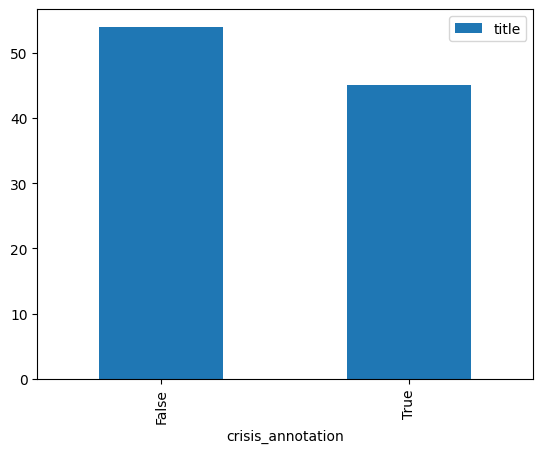

In [11]:
crisis_counts.plot(kind='bar', y='title')
plt.show()

### Data Cleaning and Preprocessing

In [84]:
# Check for missing values
print(df.isnull().sum())

# If there are missing values in the 'content' column, remove those rows
df = df.dropna(subset=['content'])

title                0
published_date       0
content              0
url                  0
crisis_annotation    0
dtype: int64


In [85]:
df['processed_content'] = df['content'].apply(lambda x: clean_text(x))
df['tokens'] = df['processed_content'].apply(word_tokenize)

In [86]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    filtered = [word for word in tokens if word not in stop_words]
    return filtered

df['tokens'] = df['tokens'].apply(remove_stopwords)

In [ ]:
#from nltk.stem import PorterStemmer

#stemmer = PorterStemmer()

#def apply_stemming(tokens):
#    return [stemmer.stem(token) for token in tokens]

#df['tokens'] = df['tokens'].apply(apply_stemming)

In [87]:
df['processed_content'] = df['tokens'].apply(' '.join)

In [88]:
df

,title,published_date,content,url,crisis_annotation,processed_content,tokens
0,Is Amazon done disrupting retail?,"Published Dec. 5, 2022",Amazon has spent the better part of a quarter ...,https://www.retaildive.com/news/amazon-done-di...,True,amazon ha spent better part quarter century fo...,"[amazon, ha, spent, better, part, quarter, cen..."
1,"As consumers return to stores, why would Amazo...","Published July 25, 2022",The pandemic supercharged e-commerce as even m...,https://www.retaildive.com/news/Why-amazon-shu...,True,pandemic supercharged ecommerce even consumer ...,"[pandemic, supercharged, ecommerce, even, cons..."
2,Amazon continues to open suburban Go locations...,"Published Feb. 13, 2023",Dive Brief:Amazon will expand its suburban Go ...,https://www.retaildive.com/news/amazon-go-open...,False,dive brief amazon expand suburban go cstore co...,"[dive, brief, amazon, expand, suburban, go, cs..."
3,Amazon buys mechatronics firm to fold into rob...,"Published Sept. 14, 2022",Dive Brief:Amazonsaid last weekit had agreed t...,https://www.retaildive.com/news/Amazon-buys-Cl...,False,dive brief amazonsaid last weekit agreed buy b...,"[dive, brief, amazonsaid, last, weekit, agreed..."
4,Amazon offers sellers free software to speed f...,"Published Sept. 20, 2022",Dive Brief:Amazonannounced Thursdayit would of...,https://www.retaildive.com/news/amazon-provide...,True,dive brief amazonannounced thursdayit would of...,"[dive, brief, amazonannounced, thursdayit, wou..."
...,...,...,...,...,...,...,...
94,"Grove Collaborative expands into Walmart, Amazon","Published Feb. 14, 2023","Expanding its wholesale channels, Grove Collab...",https://www.retaildive.com/news/grove-collabor...,False,expanding wholesale channel grove collaborativ...,"[expanding, wholesale, channel, grove, collabo..."
95,Amazon rebrands discounted membership as it la...,"Published Oct. 4, 2022",Dive Brief:Amazon unveiled a hub for discounts...,https://www.retaildive.com/news/amazon-launche...,True,dive brief amazon unveiled hub discount afford...,"[dive, brief, amazon, unveiled, hub, discount,..."
96,Amazon schedules Prime Day for mid-July,"Published June 16, 2022",Dive Brief:Prime Day this yearwill commenceat ...,https://www.retaildive.com/news/amazon-prime-d...,True,dive brief prime day yearwill commenceat midni...,"[dive, brief, prime, day, yearwill, commenceat..."
97,What Amazon’s product updates say about its st...,"Published Sept. 29, 2022",Amazon’s latest product announcements and upda...,https://www.retaildive.com/news/amazon-product...,False,amazon latest product announcement update wedn...,"[amazon, latest, product, announcement, update..."


### NLP Tasks to gather insights related e-commerce crisis

In [89]:
# Select only the articles annotated as related to the crisis
crisis_articles = df[df['crisis_annotation'] == 1]['processed_content']

# Create the TF-IDF vectorizer with adjusted parameters
vectorizer = TfidfVectorizer(max_features=1000)

# Apply the vectorizer
tfidf_matrix = vectorizer.fit_transform(crisis_articles)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

print("Key terms associated with crisis-related articles:")
print(words)

Key terms associated with crisis-related articles:
['ability' 'able' 'abroad' 'abuse' 'accelerate' 'access' 'according'
 'account' 'acquisition' 'across' 'action' 'active' 'activity' 'actually'
 'ad' 'add' 'added' 'adding' 'addition' 'additional' 'address' 'addressed'
 'adjust' 'adobe' 'adore' 'advantage' 'advertising' 'affected' 'ago'
 'agreed' 'agreement' 'ahead' 'air' 'airport' 'alexa' 'alleged' 'allow'
 'allowed' 'allowing' 'allows' 'almost' 'along' 'already' 'also' 'always'
 'amazon' 'amazonrelated' 'america' 'american' 'among' 'amount' 'analyst'
 'analytics' 'andy' 'angeles' 'announced' 'announcement' 'annual'
 'another' 'app' 'apparel' 'applies' 'approach' 'area' 'around'
 'assistant' 'attention' 'attorney' 'audience' 'august' 'authority'
 'automated' 'available' 'average' 'avoid' 'away' 'aws' 'back' 'bad'
 'based' 'beauty' 'become' 'began' 'begin' 'behavior' 'behemoth' 'behind'
 'belief' 'believe' 'benefit' 'best' 'better' 'beyond' 'bezos' 'big'
 'bigger' 'biggest' 'billion' 'b

From the list of keywords, we can infer that these crisis-related articles revolve around several interconnected themes:

**E-commerce and Retail Industry:** Words like 'amazon', 'ecommerce', 'online', 'retail', 'store', 'brickandmortar', 'shop', 'customer', 'consumer', 'product', 'brand', 'seller', 'purchase' and 'sale' suggest the main focus is on e-commerce and retail sectors. It could indicate an exploration of crisis scenarios within these sectors, possibly relating to competition, customer behavior, or product availability.

**Supply Chain and Logistics:** Keywords such as 'supply', 'distribution', 'logistics', 'delivery', 'shipping', 'cargo', 'transportation', 'warehouse', 'inventory', and 'fulfillment' point towards supply chain and logistics related issues. This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.

**Technology and Automation:** Words like 'tech', 'technology', 'automation', 'machine', 'digital', 'data', 'analytics', 'cloud', 'drone', 'ai', 'device', and 'app' indicate a strong technology and automation component. It suggests that these articles might be discussing the role of technology in crisis management or how the crisis is affecting technological advancements.

**Economic Impact and Financial Challenges:** Terms such as 'economy', 'revenue', 'profit', 'margin', 'cost', 'investment', 'financial', 'growth', 'decline', 'loss', 'inflation', 'capital', 'budget', 'dollar', 'tax', 'price', 'spending' denote a financial context. This could mean the articles discuss the economic consequences of a crisis or financial challenges during a crisis.

**Workforce Management:** Words like 'employee', 'job', 'labor', 'hiring', 'work', 'management', 'team', 'union', 'employer' suggest a focus on workforce management. It might reflect the impact of crisis on employment, labor issues, or managing workforce during crisis times.

**Legal and Regulatory Issues:** Terms such as 'lawsuit', 'legal', 'law', 'regulation', 'compliance', 'policy', 'rule', 'authority', 'rights', 'fraud', 'counterfeit' indicate a legal and regulatory context. This suggests that the articles might delve into legal issues arising from a crisis or regulatory measures implemented in response to a crisis.

**Consumer Behavior and Market Trends:** 'Consumer', 'behavior', 'trend', 'demand', 'shopping', 'market', 'competition', 'choice', 'preference', 'taste', 'branding' point towards a focus on understanding how consumer behavior is changing due to a crisis, and how market trends are evolving.

**Public Health and Safety:** Keywords like 'pandemic', 'health', 'safety', 'hygiene', 'care', 'risk', 'protection', 'emergency', 'medical', 'hospital' suggest that the articles may discuss a public health crisis or the impact of such a crisis on the sectors under discussion.

This array of terms shows that the impact of crises is multidimensional, affecting various facets of business operations and society at large. The interplay between these themes can provide a holistic understanding of crisis management and resilience.

In [91]:
# List of keywords
keywords = words
keywords_string = ', '.join(keywords)

# Ask GPT-3 to categorize the keywords into crisis topics
prompt = f"These are some keywords related to recent {company} issues: {keywords_string}.\
\nPlease group these into main crisis topics, each representing a specific type of crisis or issue,\
and provide a one-line explanation for each topic. Consider issues related to employees, finance,\
supply chain, logistics, legal and regulatory matters, and other areas relevant to business operations.\
\nFor example, if some of the keywords were 'delivery', 'logistics', 'inventory', and 'supply chain',\
a possible crisis topic could be 'Supply Chain and Logistics: This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.'"

response = openai.Completion.create(engine="text-davinci-003", prompt=prompt, temperature=0.3, max_tokens=500)

# Dictionary to store the crisis topics and their descriptions
crisis_topics_dict = {}

# Get the crisis topics
crisis_topics = response.choices[0].text.strip().split('\n')
for topic in crisis_topics:
    if topic.strip():  # This will check if the topic is not blank
        # Split the topic and its description
        topic_name, topic_description = topic.split(': ')
        crisis_topics_dict[topic_name] = topic_description

# We can now access the crisis topics and their descriptions from the dictionary
print(crisis_topics_dict)


{'Employee Issues': 'This suggests there may be a crisis related to employee rights, wages, or working conditions.', 'Finance': 'This suggests there may be a crisis related to financial performance, investments, or budgeting.', 'Supply Chain and Logistics': 'This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.', 'Legal and Regulatory Matters': 'This suggests there may be a crisis related to laws, regulations, or compliance.', 'Other Areas Relevant to Business Operations': 'This suggests there may be a crisis related to other areas of business operations, such as marketing, customer service, or data security.'}


In [21]:
# Remove 'Published ' from the date string
df['published_date'] = df['published_date'].str.replace('Published ', '')

# Convert the 'published_date' column to datetime
df['published_date'] = pd.to_datetime(df['published_date'])

In [24]:
# Resample the data to get the count of crisis-related articles per month
monthly_counts = df[df['crisis_annotation'] == 1].resample('M', on='published_date').size()

# Find the month with the most crisis-related articles
most_crisis_month = monthly_counts.idxmax()
most_crisis_month = most_crisis_month.to_period('M')

# Create a dictionary from the data
id2word = corpora.Dictionary(df['tokens'])

# Create corpus
texts = df['tokens']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

def assign_topics(lda_model, corpus):
    topic_assignments = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        # Sort the topics by their assigned proportion, in descending order
        topics.sort(key=lambda x: x[1], reverse=True)
        # Assign this document to the topic with the highest proportion
        topic_assignments.append(topics[0][0])
    return topic_assignments

# Add a new column to the DataFrame with the topic assignments
df['topic'] = assign_topics(lda_model, corpus)

# Now we can group our DataFrame by month and topic, and count the number of articles in each group
monthly_topic_counts = df[df['crisis_annotation'] == 1].groupby([df['published_date'].dt.to_period('M'), 'topic']).size()

# Find the most common topic for the month with the most crisis-related articles
most_common_topic = monthly_topic_counts[most_crisis_month].idxmax()

# Get the articles from the month with the most crisis-related articles assigned to the most common topic
most_crisis_month_articles = df[(df['published_date'].dt.to_period('M') == most_crisis_month) & (df['topic'] == most_common_topic)]

# Print the titles of these articles
print(most_crisis_month_articles['title'])

1     As consumers return to stores, why would Amazo...
45    Amazon cancels, delays wave of warehouse plans...
53    Amazon Business debuts first major campaign in...
62     Adore Me's uphill battle against fakes on Amazon
80    Amazon leans on non-retail business as e-comme...
93                  Inflation reshapes Amazon Prime Day
Name: title, dtype: object


In [25]:
# Create an empty list to store the titles
article_titles = []

# Iterate over the articles and append the titles to the list
for index, row in most_crisis_month_articles.iterrows():
    title = row['title']
    article_titles.append(title)

# Print the list of titles
print(article_titles)

['As consumers return to stores, why would Amazon shut the door?', 'Amazon cancels, delays wave of warehouse plans as e-commerce demand cools', 'Amazon Business debuts first major campaign in grab at office supplies category', "Adore Me's uphill battle against fakes on Amazon", 'Amazon leans on non-retail business as e-commerce sales fall for the second straight quarter', 'Inflation reshapes Amazon Prime Day']


In [92]:
# Convert the list of article headlines into a single string
article_headlines_str = "\n".join(article_titles)

# Use GPT-3 to generate crisis topics from the article headlines
response = openai.Completion.create(
  engine="text-davinci-002",
  prompt=f"The following are some article headlines related to crises at {company}:\n{article_headlines_str}\n\nPlease identify potential crisis topics from these headlines and provide a one-line explanation for each topic.\
  \nFor example: 'Customer dissatisfaction': 'This suggests there may be issues with customer service or product quality that are leading to unhappy customers.'",
  temperature=0.5,
  max_tokens=500
)

# Print the crisis topics
crisis_topics1 = response.choices[0].text.strip().split('\n')
crisis_topics1 = [topic.replace('-', '').strip() for topic in crisis_topics1 if topic.strip() and not topic.startswith("-The")]
for topic in crisis_topics1:
    if topic.strip():  # This will check if the topic is not blank
        # Split the topic and its description
        topic_name, topic_description = topic.split(': ')
        # Remove the double quotes from the topic name and description
        topic_name = topic_name.strip("'").strip('"')
        topic_description = topic_description.strip("'").strip('"')
        # Add the topic and description to the dictionary
        crisis_topics_dict[topic_name] = topic_description

In [27]:
print(crisis_topics1)

['Amazon shutting down warehouses: This could be due to a decrease in demand for their products, indicating that people are shopping less online.', "Adore Me's battle against fakes on Amazon: This suggests that there are a lot of counterfeit products being sold on Amazon, which could lead to customers being unhappy with their purchases."]


In [28]:
print(crisis_topics_dict)

{'Employee Issues': 'This suggests there may be a crisis related to employee rights, wages, or working conditions.', 'Finance': 'This suggests there may be a crisis related to financial losses, budgeting, or investments.', 'Supply Chain and Logistics': 'This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.', 'Legal and Regulatory Matters': 'This suggests there may be a crisis related to compliance with laws and regulations, or legal disputes.', 'Other Business Operations': 'This suggests there may be a crisis related to other areas of business operations, such as branding, advertising, or customer service.', 'Amazon shutting down warehouses': 'This could be due to a decrease in demand for their products, indicating that people are shopping less online.', "Adore Me's battle against fakes on Amazon": 'This suggests that there are a lot of counterfeit products being sold on Amazon, which could lead to customers b

In July 2022, Amazon faced numerous challenges leading to a surge in crisis-related articles. These included scaling back their private label business, logistical stressors linked to their Newark hub, a major campaign aimed at the office supplies category, offering incentives such as free Grubhub membership ahead of Prime Day, leaning towards non-retail business due to falling e-commerce sales, litigation against Facebook group administrators over fake reviews, and inflation impacting Prime Day. These issues indicate a period of strategic shifts and difficulties for Amazon, underlining the complexities of managing various aspects of a vast business ecosystem in a rapidly changing market environment.

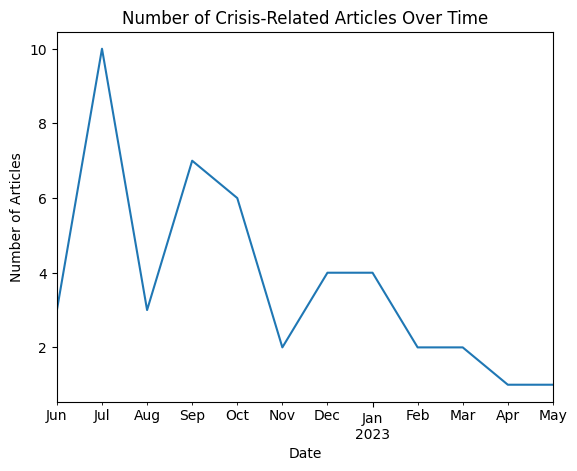

In [29]:
# Plot the data
monthly_counts.plot()
plt.title('Number of Crisis-Related Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

In [30]:
# Printing the model topics
for i in range(0, 5):
    words = lda_model.show_topic(i, topn=10)
    print(f"Topic #{i+1}:")
    for word, prob in words:
        print(f"{word}: {prob}")
    print("\n")

Topic #1:
amazon: 0.02494663931429386
company: 0.008963723666965961
customer: 0.008174818940460682
said: 0.007705681957304478
return: 0.007477372419089079
order: 0.006954679265618324
ha: 0.006730970460921526
ups: 0.006439867429435253
worker: 0.006154962349683046
delivery: 0.00566596444696188


Topic #2:
amazon: 0.030176687985658646
company: 0.01326399389654398
said: 0.011449876241385937
ha: 0.009485221467912197
year: 0.00934182945638895
store: 0.007085494697093964
retail: 0.006980807054787874
business: 0.006101679056882858
sale: 0.005935764405876398
according: 0.005927800666540861


Topic #3:
amazon: 0.016450267285108566
prime: 0.008256820961833
said: 0.0068284571170806885
company: 0.006758228875696659
year: 0.005830931011587381
ups: 0.005283422768115997
u: 0.005217659752815962
customer: 0.005014127120375633
facility: 0.004972499329596758
delivery: 0.004803657066076994


Topic #4:
amazon: 0.026587478816509247
said: 0.007656811736524105
company: 0.006460313685238361
injury: 0.0056516495

In [31]:
def print_topic_words(lda_model, topic_id, num_words=10):
    # Print the words most associated with a given topic
    words = lda_model.show_topic(topic_id, num_words)
    print("Topic", topic_id)
    for word, prob in words:
        print(word, prob)

# For example, to print the top 10 words for most_common_topic:
print_topic_words(lda_model, most_common_topic, 10)

Topic 1
amazon 0.030176688
company 0.013263994
said 0.011449876
ha 0.0094852215
year 0.009341829
store 0.0070854947
retail 0.006980807
business 0.006101679
sale 0.0059357644
according 0.0059278007


In [32]:
# Use English stopwords
r = Rake()

# Concatenate all crisis-related articles into one text
text = ' '.join(crisis_articles)

# Extract keywords
r.extract_keywords_from_text(text)

# Get the top key phrases
key_phrases = r.get_ranked_phrases()[:1]

print("Key phrases in crisis-related articles:")
print(key_phrases)

Key phrases in crisis-related articles:
['amazon ha spent better part quarter century forcing retailer stripe innovate speed compete company premised great disruption laser focus customer easing process shopping paying winnowing delivery time couple day le slashing pricesbut ecommerce giant effect sector appears waning extent rival like walmart target done lot catching boosting ecommerce leveraging many store independent retailer including bookstore first encountered amazon new competitor survived amazon still dominates online sale uswith shareaccording emarketer brickandmortar store still retail sale according u department commerce ecommerce also remains expensive way sell productsincluding amazon last month warned profit could vanish holiday quarterin fact surging height pandemic amazon retail sale floundered year appears scrutinizing operation new ceo andy jassy year companyshuttered mostof nongrocery physical store company alsocanceled postponed dozen warehousesplanned expensive ex

## Reviews

In [33]:
base_url1 = f"https://www.consumeraffairs.com/online/{company}.html?"

reviews_list = []

for page in range(1, 8):
    url = f'{base_url1}page={page}#sort=recent&filter=none'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    reviews = soup.select('.rvw.js-rvw')

    for review in reviews:
        rating = float(review.select_one('.stars-rtg--sm')['data-rating'])
        author = review.select_one('.rvw-aut__inf-nm').get_text(strip=True)
        verified = 'Verified Reviewer' in review.select_one('.rvw-aut__inf-ver').get_text(strip=True)
        date = review.select_one('.ca-txt-cpt').get_text(strip=True)
        content = review.select_one('.rvw-bd p').get_text(strip=True)

        reviews_list.append({
            'rating': rating,
            'author': author,
            'verified': verified,
            'date': date,
            'content': content
        })

df1 = pd.DataFrame(reviews_list)
print(df1)

    rating                    author  verified  \
0      5.0    Lakesha of Buckeye, AZ      True   
1      5.0      Sanjay of Auburn, AL      True   
2      5.0            R of Cocoa, FL      True   
3      5.0  ankit of San Antonio, TX      True   
4      5.0        Joyce of Macon, GA      True   
..     ...                       ...       ...   
65     3.0         Ron of Concho, AZ      True   
66     1.0  Gregory of Bradenton, FL      True   
67     1.0   O. of Silver Spring, MD      True   
68     1.0      Karey of Memphis, TN      True   
69     1.0        AREA of Tucson, AZ      True   

                              date  \
0   Original review: April 3, 2023   
1   Original review: Oct. 18, 2022   
2   Original review: July 17, 2022   
3    Original review: July 7, 2022   
4    Original review: May 16, 2022   
..                             ...   
65    Original review: May 8, 2023   
66    Original review: May 7, 2023   
67    Original review: May 6, 2023   
68    Original revi

### Data Cleaning and Preprocessing

In [34]:
# Check for missing values
print(df1.isnull().sum())

# If there are missing values in the 'content' column, remove those rows
df1 = df1.dropna(subset=['content'])

rating      0
author      0
verified    0
date        0
content     0
dtype: int64


In [35]:
df1['processed_content'] = df1['content'].apply(lambda x: clean_text(x))
df1['tokens'] = df1['processed_content'].apply(word_tokenize)
#df1['tokens'] = df1['tokens'].apply(remove_stopwords)
df1['processed_content'] = df1['tokens'].apply(' '.join)

In [36]:
df1

,rating,author,verified,date,content,processed_content,tokens
0,5.0,"Lakesha of Buckeye, AZ",True,"Original review: April 3, 2023",Amazon Prime Student is a great option for stu...,amazon prime student is a great option for stu...,"[amazon, prime, student, is, a, great, option,..."
1,5.0,"Sanjay of Auburn, AL",True,"Original review: Oct. 18, 2022",I have been had Amazon Home Warranty for almos...,i have been had amazon home warranty for almos...,"[i, have, been, had, amazon, home, warranty, f..."
2,5.0,"R of Cocoa, FL",True,"Original review: July 17, 2022",I have been ordering from Amazon forever it se...,i have been ordering from amazon forever it se...,"[i, have, been, ordering, from, amazon, foreve..."
3,5.0,"ankit of San Antonio, TX",True,"Original review: July 7, 2022",The primary uses of the Kindle gadget are read...,the primary us of the kindle gadget are readin...,"[the, primary, us, of, the, kindle, gadget, ar..."
4,5.0,"Joyce of Macon, GA",True,"Original review: May 16, 2022",I like Amazon because they do their very best ...,i like amazon because they do their very best ...,"[i, like, amazon, because, they, do, their, ve..."
...,...,...,...,...,...,...,...
65,3.0,"Ron of Concho, AZ",True,"Original review: May 8, 2023",Amazon prime movies are Great. No issues. Howe...,amazon prime movie are great no issue however ...,"[amazon, prime, movie, are, great, no, issue, ..."
66,1.0,"Gregory of Bradenton, FL",True,"Original review: May 7, 2023",I have been ordering of Amazon for a decade. I...,i have been ordering of amazon for a decade i ...,"[i, have, been, ordering, of, amazon, for, a, ..."
67,1.0,"O. of Silver Spring, MD",True,"Original review: May 6, 2023",Ordering online is supposed to facilitate peop...,ordering online is supposed to facilitate peop...,"[ordering, online, is, supposed, to, facilitat..."
68,1.0,"Karey of Memphis, TN",True,"Original review: May 6, 2023",Amazon charges you for two-day delivery and mo...,amazon charge you for twoday delivery and mont...,"[amazon, charge, you, for, twoday, delivery, a..."


### NLP Tasks to gather insights related to e-commerce crisis

In [37]:
# Initialize the sentiment analysis pipeline
nlp = pipeline('sentiment-analysis')

# Perform sentiment analysis, count sentiments and collect negative reviews
sentiment_counts = {"POSITIVE": 0, "NEGATIVE": 0}

negative_reviews = []

for index, row in df1.iterrows():
    review = row["processed_content"]
    result = nlp(review)[0]
    sentiment = result['label']
    sentiment_counts[sentiment] += 1
    score = result['score']
    print(f"{sentiment} sentiment with confidence {score}: {review}")
    if sentiment == 'NEGATIVE':
        negative_reviews.append(review)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\visha\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activ

POSITIVE sentiment with confidence 0.9550009369850159: amazon prime student is a great option for student looking to save money not paying for shipping is the biggest save in my opinion a a working mom of three that is also a student it save me ton of time with free shipping and i get thing i need quickly and sometimes a early a the next day while enjoying all the free streaming service and book that a regular prime membership ha to offer for half the price amazon prime student is only available for college student and it offer so many thing to help make college life easier this is why amazon prime is the nobrainer that i use to order my school supply and clothes and even to watch movie in between class i think amazon prime student is a great investment for all college student
NEGATIVE sentiment with confidence 0.9991119503974915: i have been had amazon home warranty for almost yr and i have called them time regarding issue but both time i got disappointed when they called for sale the

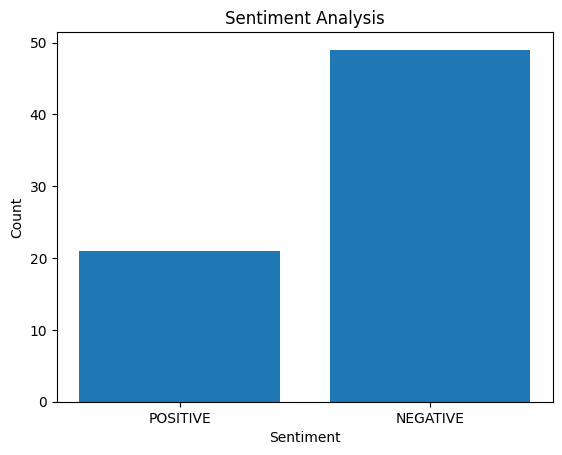

In [38]:
# Create a bar plot of sentiment counts
sentiments = list(sentiment_counts.keys())
counts = list(sentiment_counts.values())

plt.bar(sentiments, counts)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis")
plt.show()

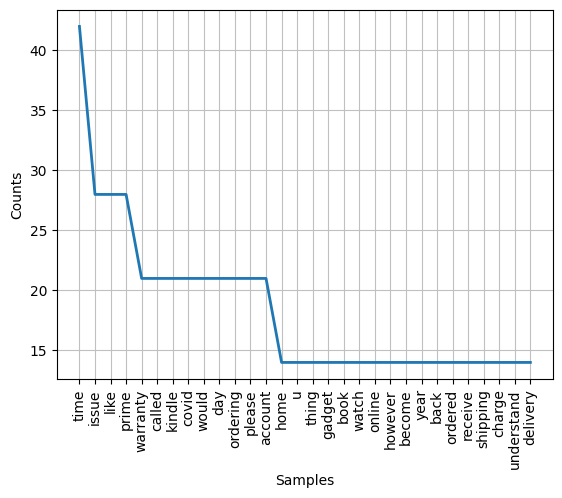

[('time', 42), ('issue', 28), ('like', 28), ('prime', 28), ('warranty', 21), ('called', 21), ('kindle', 21), ('covid', 21), ('would', 21), ('day', 21), ('ordering', 21), ('please', 21), ('account', 21), ('home', 14), ('u', 14), ('thing', 14), ('gadget', 14), ('book', 14), ('watch', 14), ('online', 14), ('however', 14), ('become', 14), ('year', 14), ('back', 14), ('ordered', 14), ('receive', 14), ('shipping', 14), ('charge', 14), ('understand', 14), ('delivery', 14)]


In [42]:
# get the English stopwords
stop_words = set(stopwords.words('english'))

# extend stop words to include common words in reviews that don't provide much information
stop_words.update([company1, 'order', 'product', 'customer', 'service', 'wa'])

# tokenize the reviews, remove stopwords, and perform frequency distribution
negative_reviews_words = [word for review in negative_reviews for word in word_tokenize(review) if word not in stop_words]
fdist = FreqDist(negative_reviews_words)

common_words = fdist.most_common(30)

# plot the frequency distribution of the top 30 words
fdist.plot(30)

# print the 30 most common words in negative reviews
print(common_words)

In [93]:
# List of keywords
keywords_string = ', '.join([f"'{word[0]}' mentioned {word[1]} times" for word in common_words])

# Ask GPT-3 to categorize the keywords into crisis topics
prompt = f"These are some keywords and their frequencies related to recent negative reviews: {keywords_string}.\
\nPlease group these into potential crisis topics, each representing a generalized category of crisis,\
and provide a one-line explanation for each topic without mentioning the keywords."

response = openai.Completion.create(engine="text-davinci-003", prompt=prompt, temperature=0.3, max_tokens=500)

# Get the crisis topics
crisis_topics2 = response.choices[0].text.strip().split('\n')
for topic in crisis_topics2:
    if topic.strip():  # This will check if the topic is not blank
        # Split the topic and its description
        topic_parts = topic.split(': ', 1)
        if len(topic_parts) == 2:
            # Strip off the '1. ', '2. ', etc. part from the key
            topic_name = topic_parts[0].split('. ', 1)[1] if '. ' in topic_parts[0] else topic_parts[0]
            topic_description = topic_parts[1]
            # Remove the double quotes from the topic name and description
            topic_name = topic_name.strip("'").strip('"')
            topic_description = topic_description.strip("'").strip('"')
            # Add the topic and description to the dictionary
            crisis_topics_dict[topic_name.strip()] = topic_description.strip()

# We can now access the crisis topics and their descriptions from the dictionary
print(crisis_topics_dict)

{'Employee Issues': 'This suggests there may be a crisis related to employee rights, wages, or working conditions.', 'Finance': 'This suggests there may be a crisis related to financial performance, investments, or budgeting.', 'Supply Chain and Logistics': 'This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.', 'Legal and Regulatory Matters': 'This suggests there may be a crisis related to laws, regulations, or compliance.', 'Other Areas Relevant to Business Operations': 'This suggests there may be a crisis related to other areas of business operations, such as marketing, customer service, or data security.', 'Amazon shutting down warehouses': "This suggests that there may be issues with the company's ecommerce business that are leading to a decline in demand.", 'Amazon Business debuts first major campaign': "This suggests that there may be issues with the company's business model that are leading to a need 

In [49]:
# Define the stopwords list
stop_words = set(stopwords.words('english'))
stop_words.update(string.punctuation)

# Tokenize the negative reviews
negative_reviews_tokens = [word_tokenize(review) for review in negative_reviews]

# Remove stopwords from the tokens
negative_reviews_tokens = [[token.lower() for token in tokens if token.lower() not in stop_words] for tokens in negative_reviews_tokens]

# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(negative_reviews_tokens)

# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(review) for review in negative_reviews_tokens]

# Create the LDA model: model
lda = LdaModel(corpus=corpus,
               id2word=dictionary,
               num_topics=5, 
               random_state=42,
               update_every=1,
               chunksize=100,
               passes=20)
# Print the model topics
for i in range(0, 5):
    words = lda.show_topic(i, topn=10)
    print(f"Topic #{i+1}:")
    for word, prob in words:
        print(f"{word}: {prob}")
    print("\n")

Topic #1:
account: 0.049933165311813354
amazon: 0.049918536096811295
please: 0.03344729542732239
review: 0.03344506025314331
u: 0.016961611807346344
result: 0.0169586930423975
email: 0.01695861481130123
removed: 0.016958491876721382
submitted: 0.016958389431238174
decision: 0.01695837639272213


Topic #2:
kindle: 0.07832610607147217
book: 0.05246305465698242
gadget: 0.05246215686202049
like: 0.0266137532889843
however: 0.026605185121297836
online: 0.026604879647493362
issue: 0.02660476230084896
become: 0.026604728773236275
watch: 0.026603730395436287
electronic: 0.026601504534482956


Topic #3:
amazon: 0.07586556673049927
ordering: 0.021894387900829315
box: 0.021892210468649864
decent: 0.021892137825489044
time: 0.021892046555876732
dont: 0.02189149335026741
ordeal: 0.02189137041568756
refund: 0.021891219541430473
job: 0.021891005337238312
used: 0.021890917792916298


Topic #4:
amazon: 0.052568040788173676
prime: 0.04210325703024864
time: 0.03165474161505699
warranty: 0.031654383987188

In [52]:
# Assuming that negative_reviews is a list of negative review texts
corpus = negative_reviews

# Create a list of stop words
stop_words = vectorizer.get_stop_words()

# Create a TfidfVectorizer and fit it on the corpus
vectorizer = TfidfVectorizer(max_features=1000, lowercase=True, stop_words='english')
X = vectorizer.fit_transform(corpus)

# Perform LDA topic modeling
num_topics = 5  # Number of topics to extract
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx+1}:")
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(", ".join(top_words))
    print()

Topic #1:
amazon, membership, total, ordering, product, customer, money, supplement, manufacturer, satisfied

Topic #2:
kindle, book, gadget, electronic, device, know, primary, platform, downloading, owner

Topic #3:
called, warranty, home, time, yr, disappointed, regarding, told, got, sale

Topic #4:
prime, covid, order, wa, faster, day, product, issue, amazon, just

Topic #5:
account, review, email, noticed, submitted, contact, content, contribute, reviewing, result



In [53]:
# number of topics to extract
n_topics = 5

# Create a list of stop words
stop_words = list(vectorizer.get_stop_words())

# Create a TfidfVectorizer and fit it on the corpus
vectorizer = TfidfVectorizer(max_features=1000, lowercase=True, stop_words=stop_words)
tf = vectorizer.fit_transform(corpus)

# Use LatentDirichletAllocation to find the topics
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

# Print the top words associated with each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10)

Topic #0: called warranty account kindle book review gadget home amazon unusual
Topic #1: prime membership total covid product charge delivery month wa order
Topic #2: supplier discovered directly return returned buy cost recently ordering manufacturer
Topic #3: box job used ordeal people amazon going decent refund avail
Topic #4: waste ordeal job situation sure lot policy people box decision


In [54]:
def get_top_words(model, feature_names, n_top_words):
    top_words_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words_dict[f"Topic #{topic_idx}"] = topic_words
    return top_words_dict

top_words = get_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10)

In [94]:
# Convert the dictionary to a string for the prompt
topics_string = '\n'.join([f"{topic}: {', '.join(words)}" for topic, words in top_words.items()])

# Ask GPT-3 to categorize the topics into crisis topics
prompt = f"These are some topics and their top words:\n{topics_string}.\n\
Please group these into potential crisis topics, each representing a generalized category of crisis,\
and provide a one-line explanation for each topic without mentioning the top words."

response = openai.Completion.create(engine="text-davinci-003", prompt=prompt, temperature=0.3, max_tokens=500)

# Get the crisis topics
crisis_topics3 = response.choices[0].text.strip().split('\n')
for topic in crisis_topics3:
    if topic.strip():  # This will check if the topic is not blank
        # Split the topic and its description
        topic_parts = topic.split('- ', 1)
        if len(topic_parts) == 2:
            # Strip off the '#X: ' part from the key
            topic_name = topic_parts[0].split(': ', 1)[1] if ': ' in topic_parts[0] else topic_parts[0]
            topic_description = topic_parts[1]
            # Remove the double quotes from the topic name and description
            topic_name = topic_name.strip("'").strip('"')
            topic_description = topic_description.strip("'").strip('"')
            # Add the topic and description to the dictionary
            crisis_topics_dict[topic_name.strip()] = topic_description.strip()

# We can now access the crisis topics and their descriptions from the dictionary
print(crisis_topics_dict)

{'Employee Issues': 'This suggests there may be a crisis related to employee rights, wages, or working conditions.', 'Finance': 'This suggests there may be a crisis related to financial performance, investments, or budgeting.', 'Supply Chain and Logistics': 'This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.', 'Legal and Regulatory Matters': 'This suggests there may be a crisis related to laws, regulations, or compliance.', 'Other Areas Relevant to Business Operations': 'This suggests there may be a crisis related to other areas of business operations, such as marketing, customer service, or data security.', 'Amazon shutting down warehouses': "This suggests that there may be issues with the company's ecommerce business that are leading to a decline in demand.", 'Amazon Business debuts first major campaign': "This suggests that there may be issues with the company's business model that are leading to a need 

In [60]:
# Assign topics to the documents
topic_assignments = lda.transform(X)

# Add the topic assignment back to the original DataFrame
df_negative_reviews = pd.DataFrame(negative_reviews, columns=["review"])
df_negative_reviews["topic_assignment"] = topic_assignments.argmax(axis=1)

# Add the topic probabilities to the DataFrame
df_negative_reviews["topic_prob"] = topic_assignments.max(axis=1)

# Topic Distribution
topic_distribution = df_negative_reviews["topic_assignment"].value_counts(normalize=True)

# Sort topic distribution by topic number
topic_distribution = topic_distribution.sort_index()

In [62]:
# Create a dictionary to hold the topic information
topics_info = {}

# Add topic distribution to the dictionary
for i, proportion in topic_distribution.iteritems():
    topics_info[i+1] = {"distribution": f"{proportion*100:.2f}%", "representative_doc": None}

# Add representative documents to the dictionary
for topic_idx in range(num_topics):
    # Select the documents that belong to the current topic
    topic_docs = df_negative_reviews[df_negative_reviews["topic_assignment"] == topic_idx]
    
    if not topic_docs.empty:  # Check if the DataFrame is not empty
        # Find the document with the highest topic probability
        representative_doc_index = topic_docs["topic_prob"].idxmax()
        representative_doc = topic_docs.loc[representative_doc_index]["review"]
        
        # Add representative document to the dictionary
        topics_info[topic_idx+1]["representative_doc"] = representative_doc

# Print the dictionary
for topic, info in topics_info.items():
    print(f"Topic #{topic}:")
    print(f"  Distribution: {info['distribution']}")
    print(f"  Representative Document: {info['representative_doc']}\n")


Topic #1:
  Distribution: 42.86%
  Representative Document: the primary us of the kindle gadget are reading and downloading electronic book it is the finest gadget for book lover and you can watch online material on ott platform however occasionally kindle owner have had a frozen screen issue that cause the device to become unresponsive if you like to know how to unfreeze kindle visit

Topic #2:
  Distribution: 28.57%
  Representative Document: amazon prime movie are great no issue however year back prior to covid when we ordered something on amazon and it wa under a prime product we would receive it within day and no shipping charge nice we live in northern az and i understand we are not next to a large city every issue wa blamed on covid well covid is done are average delivery time with prime is day i have order thing not on amazon and it get here just a fast if not faster so if you watch a lot of tv maybe prime is for you yet if you would like the product you order faster you may go

C:\Users\visha\AppData\Local\Temp\ipykernel_89944\2554195483.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, proportion in topic_distribution.iteritems():


In [95]:
# Prepare the prompt
prompt = "Here are some representative documents for different crisis topics:\n"
for topic_id, topic_info in topics_info.items():
    doc = topic_info['representative_doc']
    distribution = topic_info['distribution']
    prompt += f"\nTopic {topic_id} (Distribution: {distribution}%): '{doc}'"

prompt += "\n\nPlease group these into potential crisis topics, each representing a generalized category of crisis, and provide a one-line explanation for each topic."

# Ask GPT-3 to categorize the topics into crisis topics
response = openai.Completion.create(engine="text-davinci-003", prompt=prompt, temperature=0.3, max_tokens=500)

# Get the crisis topics
crisis_topics4 = response.choices[0].text.strip().split('\n')
for topic in crisis_topics4:
    if topic.strip():  # This will check if the topic is not blank
        # Split the topic and its description
        topic_parts = topic.split('- ', 1)
        if len(topic_parts) == 2:
            # Strip off the '#X: ' part from the key
            topic_name = topic_parts[0].split(': ', 1)[1] if ': ' in topic_parts[0] else topic_parts[0]
            topic_description = topic_parts[1]
            # Remove the double quotes from the topic name and description
            topic_name = topic_name.strip("'").strip('"')
            topic_description = topic_description.strip("'").strip('"')
            # Add the topic and description to the dictionary
            crisis_topics_dict[topic_name.strip()] = topic_description.strip()

# We can now access the crisis topics and their descriptions from the dictionary
print(crisis_topics_dict)

{'Employee Issues': 'This suggests there may be a crisis related to employee rights, wages, or working conditions.', 'Finance': 'This suggests there may be a crisis related to financial performance, investments, or budgeting.', 'Supply Chain and Logistics': 'This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.', 'Legal and Regulatory Matters': 'This suggests there may be a crisis related to laws, regulations, or compliance.', 'Other Areas Relevant to Business Operations': 'This suggests there may be a crisis related to other areas of business operations, such as marketing, customer service, or data security.', 'Amazon shutting down warehouses': "This suggests that there may be issues with the company's ecommerce business that are leading to a decline in demand.", 'Amazon Business debuts first major campaign': "This suggests that there may be issues with the company's business model that are leading to a need 

Topic distribution refers to the proportion of documents assigned to each topic within the dataset. It is calculated by counting how many documents are assigned to each topic and then dividing by the total number of documents. The topic distribution doesn't correspond directly to the topic probabilities for the representative documents.

The topic probability of a document, on the other hand, refers to the probability that a document belongs to a certain topic, as assigned by the LDA model. This probability is calculated based on the words in the document and the words associated with each topic.

Therefore, the topic probabilities for the representative documents might not match the proportions in the topic distribution. It's normal for the highest probability documents to have high probabilities (e.g., 0.8-0.9), even if the topic they belong to only makes up a small proportion of the overall dataset.

##### **Customer dissatisfaction with third-party sellers on Amazon:**
 The first topic shows high dissatisfaction regarding third-party sellers on Amazon. Customers feel deceived by unexpected return costs, including shipping fees, restocking fees, and insurance. The sentiment analysis for this topic indicates a mix of negative and neutral emotions, suggesting dissatisfaction and concern. Amazon's A-Z warranty is not viewed favorably, perceived as benefiting the sellers more than the customers.

##### **Issues with Amazon's technology replacement policy:** 
The second topic points out dissatisfaction with Amazon's replacement policy, specifically concerning cloud cameras. Customers have experienced a reduction in quality when their older, more expensive devices were replaced with cheaper, less effective models. The sentiment analysis shows a mix of negative and neutral emotions, suggesting frustration and disappointment.

##### **Delivery and product condition issues:** 
The third topic indicates that customers are having issues with the quality of the products received, especially books and console game discs, which are often damaged. Delivery timelines are also unrealistic, causing additional dissatisfaction. The sentiment analysis is predominantly negative, suggesting substantial dissatisfaction.

##### **Concerns about account security and customer service:** 
The fourth topic brings up issues with account security, with customers experiencing account hacking and unauthorized charges. The customer service experience in dealing with these issues is perceived as poor, with reports of unhelpful and disrespectful representatives. The sentiment analysis is overwhelmingly negative, indicating severe dissatisfaction and concern.

##### **Problems with international shipments and privacy:** 
The fifth topic highlights issues with Amazon's handling of international shipments, particularly when it comes to protecting customer privacy. Customers have reported issues with the visibility of their personal information in connection with their orders. The sentiment analysis shows a mix of neutral and positive emotions, suggesting some dissatisfaction but also a degree of understanding or patience.

##### **In summary,** 
While Amazon is a well-established and widely used platform, these insights point to several areas where improvements could be made, including the management of third-party sellers, product replacement policies, delivery and product quality assurance, account security, and international shipment privacy. Addressing these issues could lead to a significant increase in customer satisfaction.

## Twitter Data

In [67]:
urls = [
    'https://docs.google.com/spreadsheets/d/1rYvQw0pKlPccxXl84ppPIPNPRmGJ8nVT/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1nSneaTXvUaZ7yklWQ6MdeF518FsfXs6J/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1ZT8ZM55D0NZ15O37BzyM0tj1y_19pnHw/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1hqp2j4TNxrlmqBSltn7HOw5S7TciPQpO/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1Uimk17XPIto6Bbnc5E10GtEh3I25Bq9A/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1qNUGn3ibDubee0y9adPyDzJllgd3jJ64/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1oSwc671aJxi1JDJBIjco1G4NIVSaZ6Sx/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1kznQUrSurP4fnf64TkR-1LBE2hta2pxi/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1I9TS3Z6jJwrV__COLnHUktmbOFPuDxrB/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1otKWogeUfGJNm2ipyZja8fzrT5TP5PVO/export?format=xlsx'
]

output_files = ['Tweets1-1000.xlsx', 'Tweets1001-2000.xlsx', 'Tweets2001-3000.xlsx', 'Tweets3001-4000.xlsx',
                'Tweets4001-5000.xlsx', 'Tweets5001-6000.xlsx', 'Tweets6001-7000.xlsx', 'Tweets7001-8000.xlsx',
                'Tweets8001-9000.xlsx', 'Tweets9001-10000.xlsx']

for url, output in zip(urls, output_files):
    gdown.download(url, output)

dataframes = []

for output in output_files:
    file_path = f'{output}'
    df = pd.read_excel(file_path)
    dataframes.append(df)

# Access the dataframes using respective variable names (tw1, tw2, tw3, ...)
for i, df in enumerate(dataframes, start=1):
    globals()[f'tw{i}'] = df

c:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\parse_url.py:44: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1rYvQw0pKlPccxXl84ppPIPNPRmGJ8nVT/export?format=xlsx
To: c:\Users\visha\OneDrive\Documents\GitHub\ANLP_Retail_Crisis_Detection\Tweets1-1000.xlsx
189kB [00:00, 570kB/s] 
Downloading...
From: https://docs.google.com/spreadsheets/d/1nSneaTXvUaZ7yklWQ6MdeF518FsfXs6J/export?format=xlsx
To: c:\Users\visha\OneDrive\Documents\GitHub\ANLP_Retail_Crisis_Detection\Tweets1001-2000.xlsx
194kB [00:00, 730kB/s] 
Downloading...
From: https://docs.google.com/spreadsheets/d/1ZT8ZM55D0NZ15O37BzyM0tj1y_19pnHw/export?format=xlsx
To: c:\Users\visha\OneDrive\Documents\GitHub\ANLP_Retail_Crisis_Detection\Tweets2001-3000.xlsx
192kB [00:00, 551kB/s] 
D

In [68]:
combined_df = pd.concat([tw1, tw2, tw3, tw4, tw5, tw6, tw7, tw8, tw9, tw10], ignore_index=True)

In [69]:
columns_to_drop = ["4: Type", "5: Reply to", "6: Author", "7: Author’s real name", "8: Author's location", "9: Author’s timezone", "10: Author’s URL", "11: Author’s description", "12: Followers", "13: Follows", "15: Profile verified", "16: Profile created", "17: Retweets", "18: Likes", "19: Language", "20: Source", "21: Tweet coordinates"]
combined_df = combined_df.drop(columns=columns_to_drop)

In [70]:
combined_df

,1: Date/Time,2: Tweet,3: Hashtags,14: Tweets
0,5/11/2023 4:44 AM,Fear grows with each new vanishing. People bel...,booklaunch\nfantasy\nIARTG\nAmazon,8495
1,5/11/2023 4:44 AM,Struggling With Mental Health? Cope. What Colo...,Amazon\nStu\nAnxiety\nMotivation\nPsychology\n...,179147
2,5/11/2023 4:43 AM,"AI answer to the question ""Who can I sell this...",artificialintelligence\namazon\nmicrosoft\nfac...,205
3,5/11/2023 4:42 AM,#Hermones 4 #womenshealth #Womens suffering fr...,Hermones\nwomenshealth\nWomens\npcos\npcod\nAm...,101
4,5/11/2023 4:42 AM,Check out this #Amazon Bestseller - Windows 10...,Amazon,210532
...,...,...,...,...
9995,5/10/2023 7:53 AM,📓Don’t Leave Your Money Behind 📷How Expats Can...,Behind\nMosesChavi\nbook\namazon\namazonbookma...,1898
9996,5/10/2023 7:53 AM,"For a pair of shoelaces or something, I can un...",iPhone\namazon\ncustserv,33059
9997,5/10/2023 7:53 AM,Save 50.0% on select products from TIKTIK with...,Amazon\nClothing\nAccessories\nAd\nDeal\nBarga...,975
9998,5/10/2023 7:53 AM,📓Don’t Leave Your Money Behind\n💠How Expats Ca...,Behind\nFinancial\nMosesChavi\nbook\namazon\na...,1898


### Data Cleaning and Preprocessing

In [71]:
# Check for missing values
print(combined_df.isnull().sum())

# If there are missing values in the '2: Tweet' column, remove those rows
combined_df = combined_df.dropna(subset=['2: Tweet'])

1: Date/Time    0
2: Tweet        0
3: Hashtags     0
14: Tweets      0
dtype: int64


In [72]:
combined_df['processed_content'] = combined_df['2: Tweet'].apply(lambda x: clean_text(x))
combined_df['tokens'] = combined_df['processed_content'].apply(word_tokenize)
#combined_df['tokens'] = combined_df['tokens'].apply(remove_stopwords)
combined_df['processed_content'] = combined_df['tokens'].apply(' '.join)

In [73]:
combined_df

,1: Date/Time,2: Tweet,3: Hashtags,14: Tweets,processed_content,tokens
0,5/11/2023 4:44 AM,Fear grows with each new vanishing. People bel...,booklaunch\nfantasy\nIARTG\nAmazon,8495,fear grows with each new vanishing people beli...,"[fear, grows, with, each, new, vanishing, peop..."
1,5/11/2023 4:44 AM,Struggling With Mental Health? Cope. What Colo...,Amazon\nStu\nAnxiety\nMotivation\nPsychology\n...,179147,struggling with mental health cope what color ...,"[struggling, with, mental, health, cope, what,..."
2,5/11/2023 4:43 AM,"AI answer to the question ""Who can I sell this...",artificialintelligence\namazon\nmicrosoft\nfac...,205,ai answer to the question who can i sell this ...,"[ai, answer, to, the, question, who, can, i, s..."
3,5/11/2023 4:42 AM,#Hermones 4 #womenshealth #Womens suffering fr...,Hermones\nwomenshealth\nWomens\npcos\npcod\nAm...,101,hermones womenshealth woman suffering from pco...,"[hermones, womenshealth, woman, suffering, fro..."
4,5/11/2023 4:42 AM,Check out this #Amazon Bestseller - Windows 10...,Amazon,210532,check out this amazon bestseller window hp sff...,"[check, out, this, amazon, bestseller, window,..."
...,...,...,...,...,...,...
9995,5/10/2023 7:53 AM,📓Don’t Leave Your Money Behind 📷How Expats Can...,Behind\nMosesChavi\nbook\namazon\namazonbookma...,1898,don t leave your money behind how expat can es...,"[don, t, leave, your, money, behind, how, expa..."
9996,5/10/2023 7:53 AM,"For a pair of shoelaces or something, I can un...",iPhone\namazon\ncustserv,33059,for a pair of shoelace or something i can unde...,"[for, a, pair, of, shoelace, or, something, i,..."
9997,5/10/2023 7:53 AM,Save 50.0% on select products from TIKTIK with...,Amazon\nClothing\nAccessories\nAd\nDeal\nBarga...,975,save on select product from tiktik with promo ...,"[save, on, select, product, from, tiktik, with..."
9998,5/10/2023 7:53 AM,📓Don’t Leave Your Money Behind\n💠How Expats Ca...,Behind\nFinancial\nMosesChavi\nbook\namazon\na...,1898,don t leave your money behind how expat can es...,"[don, t, leave, your, money, behind, how, expa..."


In [74]:
# Initialize the sentiment analysis pipeline
nlp = pipeline('sentiment-analysis')

# Perform sentiment analysis, count sentiments and collect negative tweets
sentiment_counts = {"POSITIVE": 0, "NEGATIVE": 0}

negative_tweets = []

for index, row in combined_df.iterrows():
    tweet = row["processed_content"]
    result = nlp(tweet)[0]
    sentiment = result['label']
    score = result['score']
    print(f"{sentiment} sentiment with confidence {score}: {tweet}")

    sentiment_counts[sentiment] += 1

    if sentiment == 'NEGATIVE':
        negative_tweets.append(tweet)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


POSITIVE sentiment with confidence 0.9040119647979736: fear grows with each new vanishing people believe an ancient legend ha returned join lisette and her loyal band of friend a they embark on a quest to uncover the truth behind the vanishing booklaunch fantasy iartg http amazon via amazon
NEGATIVE sentiment with confidence 0.9957993626594543: struggling with mental health cope what color is your brain scan the answer are in your head and habit http amazon stu anxiety motivation psychology usa calgary regina memphis boston
NEGATIVE sentiment with confidence 0.9984226226806641: ai answer to the question who can i sell this domain to for the domain http what do you think artificialintelligence amazon microsoft facebook tesla ibm intel nvidia samsung google ai domain domain domainanme dynadot apple branding http
NEGATIVE sentiment with confidence 0.9798569083213806: hermones womenshealth woman suffering from pcos pcod available on amazon http http
NEGATIVE sentiment with confidence 0.981

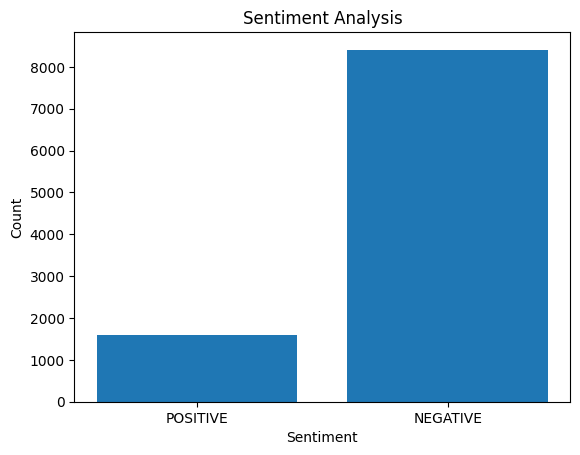

In [75]:
# Create a bar plot of sentiment counts
sentiments = list(sentiment_counts.keys())
counts = list(sentiment_counts.values())

plt.bar(sentiments, counts)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis")
plt.show()

In [76]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
# nltk.download('wordnet')

# get the English stopwords
stop_words = set(stopwords.words('english'))

# Extend stop words to include common words in tweets that don't provide much information
stop_words.update([company1, 'ml', 'x', 'u', 't',
                   'ad', 'link', 'http', 'yard', 'inch'])

# Create a Tweet tokenizer
tweet_tokenizer = TweetTokenizer()

# Clean text data
cleaned_tweets = []
lemmatizer = WordNetLemmatizer()
url_pattern = re.compile(r'http\S+|www\S+')

for tweet in negative_tweets:
    # Remove URLs
    tweet = url_pattern.sub('', tweet)

    # Tokenize using the Tweet tokenizer
    tokens = tweet_tokenizer.tokenize(tweet)

    # Lemmatization and lowercasing
    tweet = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    
    # Extend stop words
    tweet = [token for token in tweet if token not in stop_words]

    cleaned_tweets.append(tweet)

# Perform frequency distribution on cleaned tweets
cleaned_tweets_words = [word for tweet in cleaned_tweets for word in tweet]
fdist = FreqDist(cleaned_tweets_words)

# Print the 60 most common words in negative tweets
common_tweets = fdist.most_common(60)

# print the 30 most common words in negative reviews
print(common_tweets)

[('hair', 1902), ('straightener', 989), ('fabric', 938), ('iron', 778), ('curling', 714), ('deal', 626), ('black', 574), ('portable', 419), ('flat', 384), ('comb', 367), ('pack', 364), ('mini', 351), ('mat', 348), ('white', 340), ('tool', 324), ('heat', 323), ('set', 321), ('usb', 320), ('body', 314), ('light', 306), ('cotton', 300), ('resistant', 293), ('home', 287), ('cable', 287), ('woman', 282), ('straight', 282), ('blue', 277), ('brush', 271), ('silicone', 262), ('straightening', 258), ('styling', 258), ('product', 257), ('pink', 253), ('cream', 253), ('bag', 252), ('free', 250), ('book', 246), ('holder', 246), ('dog', 243), ('price', 241), ('student', 238), ('use', 236), ('wall', 228), ('men', 225), ('green', 221), ('oil', 220), ('skin', 220), ('travel', 218), ('gaming', 209), ('coupon', 208), ('cover', 202), ('gift', 202), ('baby', 201), ('case', 200), ('atc', 197), ('barber', 197), ('leather', 192), ('color', 188), ('car', 182), ('led', 179)]


In [96]:
# List of keywords
keywords_string = ', '.join([f"'{word[0]}' mentioned {word[1]} times" for word in common_tweets])

# Ask GPT-3 to categorize the keywords into crisis topics
prompt = f"These are some keywords and their frequencies related to recent negative tweets: {keywords_string}.\
\nPlease group these into potential crisis topics, each representing a generalized category of crisis,\
and provide a one-line explanation for each topic without mentioning the keywords."

response = openai.Completion.create(engine="text-davinci-003", prompt=prompt, temperature=0.3, max_tokens=500)

# Get the crisis topics
crisis_topics5 = response.choices[0].text.strip().split('\n')
for topic in crisis_topics5:
    if topic.strip():  # This will check if the topic is not blank
        # Split the topic and its description
        topic_parts = topic.split(': ', 1)
        if len(topic_parts) == 2:
            # Strip off the 'Topic X' or '#X' part from the key
            topic_name = topic_parts[0].split(' ', 1)[1] if topic_parts[0].startswith(('Topic ', '#')) else topic_parts[0]
            topic_description = topic_parts[1]
            crisis_topics_dict[topic_name.strip()] = topic_description.strip()

# You can now access the crisis topics and their descriptions from the dictionary
print(crisis_topics_dict)

{'Employee Issues': 'This suggests there may be a crisis related to employee rights, wages, or working conditions.', 'Finance': 'This suggests there may be a crisis related to financial performance, investments, or budgeting.', 'Supply Chain and Logistics': 'This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.', 'Legal and Regulatory Matters': 'This suggests there may be a crisis related to laws, regulations, or compliance.', 'Other Areas Relevant to Business Operations': 'This suggests there may be a crisis related to other areas of business operations, such as marketing, customer service, or data security.', 'Amazon shutting down warehouses': "This suggests that there may be issues with the company's ecommerce business that are leading to a decline in demand.", 'Amazon Business debuts first major campaign': "This suggests that there may be issues with the company's business model that are leading to a need 

Here are a few insights that can be drawn:

**Haircare Products:** Words like 'hair', 'straightener', 'iron', 'curling', 'comb', 'flat', 'heat', 'straight', 'brush', 'straightening', and 'styling' indicate issues related to haircare products and tools. It seems like customers are having issues with these items.

**Fabric and Clothing Items:** Words like 'fabric', 'black', 'white', 'cotton', 'woman', 'blue', 'pink', 'men', and 'leather' suggest dissatisfaction with clothing or fabric items.

**Home and Travel Items:** Words such as 'portable', 'home', 'usb', 'cable', 'light', 'mat', 'set', 'wall', 'travel', 'bag', 'holder', 'cover', 'case' and 'car' imply issues related to household items, electronics, and travel accessories.

**Deal and Price Issues:** The appearance of words like 'deal', 'price', 'coupon', 'free' and 'gift' could indicate dissatisfaction around pricing, deals or promotional offers.

**Beauty and Personal Care Products:** Words like 'body', 'cream', 'oil', 'skin', 'baby' and 'barber' suggest possible issues with personal care or beauty products.

**Other Categories:** Words like 'book', 'student', 'gaming', 'dog', 'green', 'led' could indicate potential issues in categories such as books, education, gaming, pets, and electronic items.

## Intelligent Response Generation

##### Here we are generating intelligent responses using GPT-2 and GPT-3

In [98]:
# Print the crisis topics and their descriptions
for topic, description in crisis_topics_dict.items():
    print(f"Crisis Topic: {topic}\nDescription: {description}\n")

Crisis Topic: Employee Issues
Description: This suggests there may be a crisis related to employee rights, wages, or working conditions.

Crisis Topic: Finance
Description: This suggests there may be a crisis related to financial performance, investments, or budgeting.

Crisis Topic: Supply Chain and Logistics
Description: This suggests there may be a crisis related to maintaining supply chains, issues with delivery logistics, or managing inventories.

Crisis Topic: Legal and Regulatory Matters
Description: This suggests there may be a crisis related to laws, regulations, or compliance.

Crisis Topic: Other Areas Relevant to Business Operations
Description: This suggests there may be a crisis related to other areas of business operations, such as marketing, customer service, or data security.

Crisis Topic: Amazon shutting down warehouses
Description: This suggests that there may be issues with the company's ecommerce business that are leading to a decline in demand.

Crisis Topic: Ama

In [101]:
# from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Dictionary to store the crisis topics and the company's responses
crisis_responses_dict = {}

# Loop over each crisis topic
for topic, description in crisis_topics_dict.items():
    # Prompt for the GPT-2 model
    prompt = f"""
    Crisis Topic: {topic}
    Description: {description}
    
    As a spokesperson for the company, draft a public response addressing this crisis. 
    The response should aim to maintain the company's reputation, mitigate the impact of the crisis, 
    and engage effectively with the target audience to improve the brand image.
    """
    
    # Use the GPT-2 model to generate a response
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(inputs, max_length=200, num_return_sequences=1, no_repeat_ngram_size=2, do_sample=True, top_k=50)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Store the response in the dictionary
    crisis_responses_dict[topic] = response

# Print the crisis topics and the company's responses
for topic, response in crisis_responses_dict.items():
    print(f"Crisis Topic: {topic}\nCompany Response: {response}\n")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Crisis Topic: Employee Issues
Company Response: 
    Crisis Topic: Employee Issues
    Description: This suggests there may be a crisis related to employee rights, wages, or working conditions.
    
    As a spokesperson for the company, draft a public response addressing this crisis. 
    The response should aim to maintain the company's reputation, mitigate the impact of the crisis, 
    and engage effectively with the target audience to improve the brand image.
     What are the steps you should take as a result of this incident?  The first step is not only to ask this person about the incident, and not to force their response, but to ensure that they ask the correct questions regarding this employee. Additionally, if they are not able to answer any questions and have no intention of responding, it might indicate that this company will not be able pay this case and will likely be forced into bankruptcy. Once you have clarified your reasons for not

Crisis Topic: Finance
Company Resp

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

def generate_response(prompt):
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(inputs, max_length=150, num_return_sequences=5, no_repeat_ngram_size=2, do_sample=True, top_k=50)

    responses = []
    for output in outputs:
        response = tokenizer.decode(output, skip_special_tokens=True)
        responses.append(response)
    
    return responses

prompt = "In response to the recent customer complaints about our hair related products..."
responses = generate_response(prompt)

for i, response in enumerate(responses):
    print(f"Response {i+1}: {response}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response 1: In response to the recent customer complaints about our hair related products...we have changed that policy on its main page to "Please be respectful and considerate with your hair".

And then you have your goon and your friends and the rest, as we shall see below....
:-))( )(  "I am totally happy with the way I've been treated and happy that my hair looks so well. The new "hula line" will be available and will begin sale on July 19th 2018."
Response 2: In response to the recent customer complaints about our hair related products... The latest one? We made a big cut back on our supply and only in part through the use of "fever strips". If you have ever wondered how you can get into a sweat shop or hair spa without using a hair strip on your head... If that is the case you are now well aware that you cannot take hair in and out of the hair bar. What you need now is another way of getting into sweat shops and hair salons to pay for that very expensive service. We have the rig

In [100]:
# Dictionary to store the crisis topics and the company's responses
crisis_responses_dict = {}

# Loop over each crisis topic
for topic, description in crisis_topics_dict.items():
    # Prompt for the GPT-3 model
    prompt = f"""
    Crisis Topic: {topic}
    Description: {description}
    
    As a spokesperson for the company, draft a public response addressing this crisis. 
    The response should aim to maintain the company's reputation, mitigate the impact of the crisis, 
    and engage effectively with the target audience to improve the brand image.
    """
    
    # Use the GPT-3 model to generate a response
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        temperature=0.3,
        max_tokens=500
    )

    # Store the response in the dictionary
    crisis_responses_dict[topic] = response.choices[0].text.strip()

# Print the crisis topics and the company's responses
for topic, response in crisis_responses_dict.items():
    print(f"Crisis Topic: {topic}\nCompany Response: {response}\n")

Crisis Topic: Employee Issues
Company Response: Dear valued customers and employees,

We understand that recent events have raised questions about our company’s commitment to our employees and their rights. We want to assure you that we take this matter seriously and are committed to providing a safe and fair workplace for all of our employees. 

We are actively working to review and update our policies and procedures to ensure that our employees’ rights are respected and that they are treated fairly and with respect. We are also working to ensure that our employees are paid a fair and livable wage. 

We understand that our employees are the backbone of our business and we are committed to providing them with the best possible working conditions. We are also committed to being transparent and open with our employees and customers. 

We thank you for your patience and understanding as we work to address this crisis. We are confident that our commitment to our employees and customers wil

## Model Evaluation

To evaluate the quality and relevance of generated content, especially when comparing responses generated by GPT-2 and GPT-3, a combination of qualitative and human evaluation methods is recommended.

Qualitative Evaluation: One approach is to involve domain experts who can provide subjective ratings or assessments of the generated content. These experts can evaluate the quality, relevance, and overall effectiveness of the responses based on their expertise in the domain. They can rate the responses on a scale or provide qualitative feedback to assess coherence, accuracy, and appropriateness.

Human Comparison: Another method is to compare the generated content with human-written content. This can be done by presenting both the generated responses and human-written responses to evaluators who are not aware of which responses are generated by AI models. The evaluators can then rate or rank the responses based on their quality, relevance, and overall performance. This approach helps in understanding how well the AI-generated responses compare to human-generated ones.

Automated Evaluation Metrics: While automated metrics like perplexity, BLEU score, or ROUGE score can provide quantitative measures of the generated content, they may not capture the full nuances of human language. However, these metrics can still be useful as supplementary evaluation tools to assess aspects like grammar, fluency, and lexical similarity. They can provide additional insights, but they should not be the sole basis for evaluating the generated content.

By combining qualitative evaluation through expert ratings, human comparison, and supplementary automated metrics, we can gain a comprehensive understanding of the quality, relevance, coherence, and fluency of the generated content. This multifaceted evaluation approach allows for a more accurate assessment of AI-generated responses in social media or other text generation tasks. However, due to our lack of domain experts, we will only be using automated evaluation tools.

Here, I took the top 3 generated responses, and used the BLEU and METEOR Score to evaluate the models by comparing those to possible reference responses written manually.

In [11]:
# For GPT-2

# Generated responses and reference responses
generated_responses = ["As a spokesperson for the company, draft a public response addressing this crisis.\
                       The response should aim to maintain the company's reputation, mitigate the impact of the crisis,\
                       and engage effectively with the target audience to improve the brand image.What\
                       are the steps you should take as a result of this incident?  The first step is not only to ask\
                       this person about the incident, and not to force their response, but to ensure that they ask\
                       the correct questions regarding this employee. Additionally, if they are not able to answer\
                       any questions and have no intention of responding, it might indicate that this company will not\
                       be able pay this case and will likely be forced into bankruptcy. Once you have clarified your\
                       reasons for not", " As a spokesperson for the company, draft a public response addressing this crisis.\
                       The response should aim to maintain the company's reputation, mitigate the impact of the crisis,\
                       and engage effectively with the target audience to improve the brand image.Please include an opportunity\
                       to discuss the details below, including your reasons for doing so. Please add details with an option for\
                       your contribution to an email list. Responses are subject to the Terms and conditions of use, as well as\
                       the availability of public submissions. See your support@bip.com to confirm a response.\
                       Failure to respond to this notice will result in an automated status update. We are responsible\
                       for handling any correspondence returned via this mail list, so please ensure that any replies","As a\
                       spokesperson for the company, draft a public response addressing this crisis. The response should aim\
                       to maintain the company's reputation, mitigate the impact of the crisis, and engage effectively\
                       with the target audience to improve the brand image.This statement should also include the following:\
                       a statement of what are the most important aspects to an organization's operational planning, execution,\
                       and management. In the event of a major crisis in the Company's supply chain, a series of questions about\
                       supply-chain and logistics issues should be asked. These questions include: Which aspects of supply and\
                       service use are critical to the business operating and what actions must be taken to ensure a level"]
reference_responses = ["We are aware of the recent events and the concerns they have raised about our commitment to our\
                       employees' rights. We are taking this matter seriously and are dedicated to providing a safe and\
                       equitable workplace for all our employees. We are currently reviewing our policies and procedures\
                       to ensure that our employees' rights are upheld and they are treated with dignity and respect.\
                       We understand the pivotal role our employees play in our business and are committed to ensuring\
                       they have the best possible working conditions. We appreciate your patience and understanding as\
                       we navigate this crisis and reaffirm our commitment to our employees and customers.", "We are cognizant\
                       of the concerns regarding our financial situation. We would like to reassure you that we are doing all\
                       we can to manage the situation and ensure the ongoing success of our company. We are actively seeking ways\
                       to mitigate the impact of the crisis and ensure the financial health of our company. We are also making sure\
                       our budgeting and investment strategies are robust and our financial performance remains solid.\
                       We appreciate your trust and support, and are committed to delivering high-quality service.\
                       We understand the disruptions caused by this crisis and apologize for any inconvenience.\
                       We are confident that we will come out of this crisis stronger.", "We understand the disruptions and\
                       inconveniences caused by the ongoing crisis related to our supply chain and logistics.\
                       We would like to assure you that we are doing our best to keep our supply chains operational and\
                       our delivery logistics efficient. We are actively monitoring the situation and taking all necessary\
                       measures to ensure our inventories remain stocked and our deliveries are as timely as possible.\
                       We are also striving to ensure that our products reach our customers as swiftly as possible.\
                       We understand that these are challenging times and we appreciate your patience and understanding.\
                       We are committed to providing the best possible service and will continue to work diligently to ensure\
                       the smooth running of our supply chains and delivery logistics. We thank you for your continued support."]


for generated_response, reference_response in zip(generated_responses, reference_responses):
    # Tokenize the sentences
    generated_tokens = word_tokenize(generated_response)
    reference_tokens = word_tokenize(reference_response)

    # Calculate the BLEU score
    smoothie = SmoothingFunction().method4  # We can change the method number to use a different smoothing function
    bleu_score = sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothie)
    print(f"BLEU Score: {bleu_score}")

    # Calculate the METEOR score
    score = nltk_meteor_score.meteor_score([reference_tokens], generated_tokens)
    print(f"METEOR Score: {score}")

BLEU Score: 0.022010712673435504
METEOR Score: 0.17167381974248924
BLEU Score: 0.06357372838966484
METEOR Score: 0.1940956770502225
BLEU Score: 0.013385998902638476
METEOR Score: 0.13939375750300118


In [10]:
# For GPT-3

# Generated responses and reference responses
generated_responses = ["We understand that recent events have raised questions about our company’s\
                       commitment to our employees and their rights. We want to assure you that\
                       we take this matter seriously and are committed to providing a safe and fair\
                       workplace for all of our employees. We are actively working to review and update\
                       our policies and procedures to ensure that our employees’ rights are respected\
                       and that they are treated fairly and with respect. We are also working to ensure\
                       that our employees are paid a fair and livable wage. We understand that\
                       our employees are the backbone of our business and we are committed to providing them\
                       with the best possible working conditions. We are also committed to being transparent\
                       and open with our employees and customers. We thank you for your patience and\
                       understanding as we work to address this crisis. We are confident that our commitment\
                       to our employees and customers will remain strong.", "We understand that you may have\
                       concerns about the current financial crisis that our company is facing. We want to\
                       assure you that we are doing everything in our power to address the situation and\
                       ensure that our company continues to be a reliable and successful business.\
                       We are actively working to mitigate the impact of the crisis by exploring all\
                       available options to ensure the financial stability of our company.\
                       We are also taking steps to ensure that our budgeting and investments are sound\
                       and that our financial performance remains strong. We value your trust and support,\
                       and we are committed to providing you with the highest quality of service.\
                       We understand that this crisis may have caused some disruption, and\
                       we apologize for any inconvenience. We are confident that our company\
                       will emerge from this crisis stronger than ever. Thank you for your continued\
                       support.","We understand that the current crisis related to supply chain\
                       and logistics is causing disruption and inconvenience to your daily lives.\
                       We want to assure you that we are doing our best to ensure that our supply\
                       chains remain intact and that our delivery logistics are running as smoothly as possible.\
                       We are actively monitoring the situation and taking all necessary steps to ensure that our\
                       inventories are well-stocked and that our delivery services are running as efficiently as possible.\
                       We are also working hard to ensure that our products are reaching our customers in a timely manner.\
                       We understand that this is a difficult time for everyone, and we want to thank you for your\
                       patience and understanding. We are committed to providing you with the best possible service and\
                       we will continue to work hard to ensure that our supply chains and delivery logistics are running\
                       as smoothly as possible. Thank you for your continued support."]
reference_responses = ["We are aware of the recent events and the concerns they have raised about our commitment to our\
                       employees' rights. We are taking this matter seriously and are dedicated to providing a safe and\
                       equitable workplace for all our employees. We are currently reviewing our policies and procedures\
                       to ensure that our employees' rights are upheld and they are treated with dignity and respect.\
                       We understand the pivotal role our employees play in our business and are committed to ensuring\
                       they have the best possible working conditions. We appreciate your patience and understanding as\
                       we navigate this crisis and reaffirm our commitment to our employees and customers.", "We are cognizant\
                       of the concerns regarding our financial situation. We would like to reassure you that we are doing all\
                       we can to manage the situation and ensure the ongoing success of our company. We are actively seeking ways\
                       to mitigate the impact of the crisis and ensure the financial health of our company. We are also making sure\
                       our budgeting and investment strategies are robust and our financial performance remains solid.\
                       We appreciate your trust and support, and are committed to delivering high-quality service.\
                       We understand the disruptions caused by this crisis and apologize for any inconvenience.\
                       We are confident that we will come out of this crisis stronger.", "We understand the disruptions and\
                       inconveniences caused by the ongoing crisis related to our supply chain and logistics.\
                       We would like to assure you that we are doing our best to keep our supply chains operational and\
                       our delivery logistics efficient. We are actively monitoring the situation and taking all necessary\
                       measures to ensure our inventories remain stocked and our deliveries are as timely as possible.\
                       We are also striving to ensure that our products reach our customers as swiftly as possible.\
                       We understand that these are challenging times and we appreciate your patience and understanding.\
                       We are committed to providing the best possible service and will continue to work diligently to ensure\
                       the smooth running of our supply chains and delivery logistics. We thank you for your continued support."]


for generated_response, reference_response in zip(generated_responses, reference_responses):
    # Tokenize the sentences
    generated_tokens = word_tokenize(generated_response)
    reference_tokens = word_tokenize(reference_response)

    # Calculate the BLEU score
    smoothie = SmoothingFunction().method4  # We can change the method number to use a different smoothing function
    bleu_score = sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothie)
    print(f"BLEU Score: {bleu_score}")

    # Calculate the METEOR score
    score = nltk_meteor_score.meteor_score([reference_tokens], generated_tokens)
    print(f"METEOR Score: {score}")


BLEU Score: 0.3002106684204692
METEOR Score: 0.6034100192878558
BLEU Score: 0.28669360886224554
METEOR Score: 0.6497175778465537
BLEU Score: 0.39810842492424037
METEOR Score: 0.7515918129233771


## Twitter Data Collection Trial

In [ ]:
pip install TwitterAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for TwitterAPI: filename=TwitterAPI-2.8.2-py3-none-any.whl size=14881 sha256=3f16710f26f04def81eaba2b621b77b017d0cafc7826230ea10f7d2542fa58cb
  Stored in directory: /root/.cache/pip/wheels/aa/d3/ce/649017b934d001f7113c8f461dedf29da03e4cbe2894d5f145
Successfully built TwitterAPI


In [ ]:
bearer_token = 'my_bearer_token'

url = 'https://api.twitter.com/2/tweets/search/recent'
params = {
    'query': 'Amazon',
    'tweet.fields': 'created_at',
    'max_results': 100
}
headers = {
    'Authorization': f'Bearer {bearer_token}',
}

response = requests.get(url, params=params, headers=headers)

# The response will be in JSON format, so I can convert it to a Python dictionary using .json()
data = response.json()

# Now I can interact with the data.
print(data)

{'client_id': '27104146', 'detail': 'When authenticating requests to the Twitter API v2 endpoints, you must use keys and tokens from a Twitter developer App that is attached to a Project. You can create a project via the developer portal.', 'registration_url': 'https://developer.twitter.com/en/docs/projects/overview', 'title': 'Client Forbidden', 'required_enrollment': 'Appropriate Level of API Access', 'reason': 'client-not-enrolled', 'type': 'https://api.twitter.com/2/problems/client-forbidden'}
